# Runtime Mitosis extension 

This Colab shows the runtime of standard bipartite matching using hungarian method compared to matching with our mitosis-extension. The experiment demonstrates how our extension influences the computational burden of MHT trackers.

The setup is done as follows: A standard matching is done with a cost matrix $C$ that has the size $J\times(I+J)$ with J new detections and I old objects from the subsequent frame. A cost value reflects the log-likelihood and a row can at maximum contain a cumulated sum of likelihoods $\leq 1$. The right $J\times J$ submatrix is an eye matrix with values other that 0 only on the diagonal. As described in the paper, the matching matrix $C$ is extended (in this file denote it as $C_\text{M}$) that is $J\times(2I+J)$ to allow mitosis.

We conduct experiments by randomly creating matrices $C$ of different sizes that hold the above described restrictions. Then we extend $C$ to $C_\text{M}$ and solve the bipartite matching problem with the hungarian method on both matrices. We repeat the calculations 1000 times with different initializations to reduce noise and plot the runtimes.


In [1]:
import numpy as np
from  scipy.optimize import linear_sum_assignment as hungarian
from datetime import datetime

now = datetime.now

def create_matrices(size):
  # Create costs
  c_jj = np.random.rand(size, size)
  c_ji = np.eye(size) * np.random.rand(size, 1)
  # Normalize
  sum_of_both = np.sum(c_jj, axis=1, keepdims=True) + np.sum(c_ji, axis=1, keepdims=True)
  c_jj = c_jj / sum_of_both
  c_ji = c_ji / sum_of_both
  # Concatenate
  C = np.concatenate([c_jj, c_ji], axis=1)
  C_M = np.concatenate([c_jj, c_jj, c_ji], axis=1)
  C = -np.log(C)
  C_M = -np.log(C_M)
  return C, C_M

sizes = []
runtimes_c = []
runtimes_c_m = []


for size in range(2, 100):
  matrices = [create_matrices(size) for x in range(2000)]
  t_c_start = now()
  for C, C_M in matrices:
    hungarian(C)
  t_c = (now() - t_c_start)
  t_c_m_start = now()
  for C, C_M in matrices:
    hungarian(C_M)
  t_c_m = (now() - t_c_m_start)
  sizes.append(size)
  runtimes_c.append(t_c)
  runtimes_c_m.append(t_c_m)
  print("Size", size, "Time C", t_c, "Time C_M", t_c_m, "Shapes", C.shape, C_M.shape)


C:\Users\kaiser\AppData\Local\Temp\ipykernel_24284\2499380416.py:18: RuntimeWarning: divide by zero encountered in log
  C = -np.log(C)
C:\Users\kaiser\AppData\Local\Temp\ipykernel_24284\2499380416.py:19: RuntimeWarning: divide by zero encountered in log
  C_M = -np.log(C_M)


Size 2 Time C 0:00:00.002000 Time C_M 0:00:00.001993 Shapes (2, 4) (2, 6)
Size 3 Time C 0:00:00.002000 Time C_M 0:00:00.002000 Shapes (3, 6) (3, 9)
Size 4 Time C 0:00:00.002000 Time C_M 0:00:00.002000 Shapes (4, 8) (4, 12)
Size 5 Time C 0:00:00.003000 Time C_M 0:00:00.003000 Shapes (5, 10) (5, 15)
Size 6 Time C 0:00:00.004000 Time C_M 0:00:00.005003 Shapes (6, 12) (6, 18)
Size 7 Time C 0:00:00.005000 Time C_M 0:00:00.004000 Shapes (7, 14) (7, 21)
Size 8 Time C 0:00:00.003997 Time C_M 0:00:00.005001 Shapes (8, 16) (8, 24)
Size 9 Time C 0:00:00.007000 Time C_M 0:00:00.006000 Shapes (9, 18) (9, 27)
Size 10 Time C 0:00:00.007999 Time C_M 0:00:00.006001 Shapes (10, 20) (10, 30)
Size 11 Time C 0:00:00.009006 Time C_M 0:00:00.007995 Shapes (11, 22) (11, 33)
Size 12 Time C 0:00:00.010995 Time C_M 0:00:00.011999 Shapes (12, 24) (12, 36)
Size 13 Time C 0:00:00.011001 Time C_M 0:00:00.010000 Shapes (13, 26) (13, 39)
Size 14 Time C 0:00:00.012000 Time C_M 0:00:00.009003 Shapes (14, 28) (14, 42)
Si

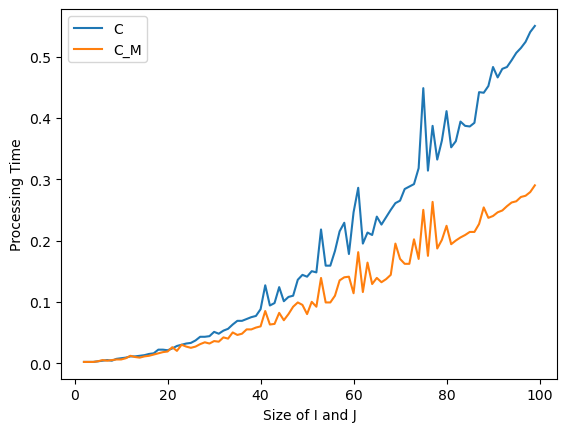

In [2]:
import matplotlib.pyplot as plt

sizes = np.asarray(sizes)
runtimes_c_converted = np.asarray([x.total_seconds() for x in runtimes_c])
runtimes_c_m_converted = np.asarray([x.total_seconds() for x in runtimes_c_m])

# plot lines
plt.plot(sizes, runtimes_c_converted, label = "C")
plt.plot(sizes, runtimes_c_m_converted, label = "C_M")
plt.legend()
plt.xlabel("Size of I and J")
plt.ylabel("Processing Time")
plt.show()

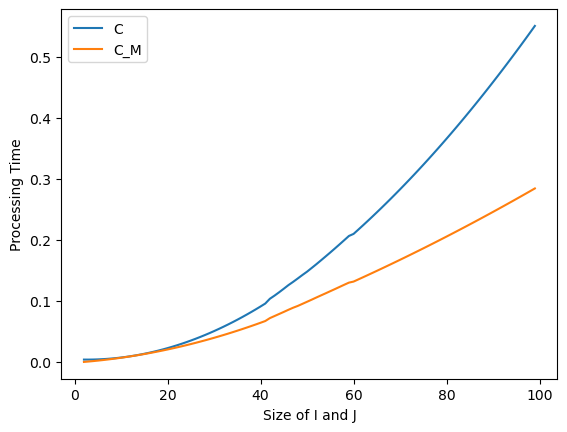

In [3]:
from scipy.signal import savgol_filter


runtimes_c_converted = savgol_filter(runtimes_c_converted, 80, 2)
runtimes_c_m_converted = savgol_filter(runtimes_c_m_converted, 80, 2)


# plot lines
plt.plot(sizes, runtimes_c_converted, label = "C")
plt.plot(sizes, runtimes_c_m_converted, label = "C_M")
plt.legend()
plt.xlabel("Size of I and J")
plt.ylabel("Processing Time")
plt.show()

In [7]:
print(f"sizes,runtimes_c,runtimes_c_m")
for i, c, cm in zip(sizes, runtimes_c_converted, runtimes_c_m_converted):
  print(f"{i},{c},{cm}")
  


sizes,runtimes_c,runtimes_c
2,0.0032687923554652496,-0.0005549457768744218
3,0.0032551094034796104,0.00010742945324918713
4,0.00336612476867797,0.0008254085774204998
5,0.0036018384510603297,0.0015989915956395166
6,0.003962250450626689,0.002428178507906237
7,0.004447360767377047,0.003312969314220661
8,0.005057169401311405,0.004253364014582789
9,0.005791676352429763,0.0052493626089926216
10,0.00665088162073212,0.006300965097450158
11,0.007634785206218477,0.007408171479955398
12,0.008743387108888834,0.00857098175650834
13,0.009976687328743189,0.009789395927108988
14,0.011334685865781544,0.011063413991757339
15,0.012817382720003899,0.012393035950453395
16,0.014424777891410254,0.013778261803197153
17,0.016156871380000607,0.015219091549988616
18,0.01801366318577496,0.016715525190827786
19,0.01999515330873331,0.01826756272571465
20,0.022101341748875663,0.01987520415464923
21,0.024332228506202015,0.021538449477631505
22,0.02668781358071237,0.02325729869466149
23,0.029168096972406722,0.02503175